In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np

In [3]:
with open('./data/LLMsuggestions_free_uncommented.json', 'r') as f1:
    LLMResults = json.load(f1)

with open('./data/allTables_free.json', 'r') as f2:
    MznResults = json.load(f2)

In [4]:
# --- Flatten LLMResults into llm_df ---
llm_rows = []
for provider, models in (LLMResults or {}).items():
    if not isinstance(models, dict):
        continue
    for model, problems in models.items():
        if not isinstance(problems, dict):
            continue
        for problem, instances in problems.items():
            if not isinstance(instances, dict):
                continue
            for instance, data in instances.items():
                if not isinstance(data, dict):
                    top3_val = None
                    time_val = None
                else:
                    top3_val = data.get('top3') if 'top3' in data else data.get('top_3') if 'top_3' in data else data.get('suggested') if 'suggested' in data else None
                    time_val = data.get('time_seconds') if 'time_seconds' in data else data.get('time') if 'time' in data else None
                if isinstance(top3_val, list):
                    top3_list = top3_val
                    top3_str = ', '.join(map(str, top3_list)) if top3_list else None
                    top1 = top3_list[0] if top3_list else None
                elif isinstance(top3_val, str):
                    parts = [p.strip() for p in top3_val.replace(';',',').split(',') if p.strip()]
                    top3_list = parts if parts else None
                    top3_str = ', '.join(parts) if parts else top3_val
                    top1 = parts[0] if parts else (top3_val or None)
                else:
                    top3_list = None
                    top3_str = None
                    top1 = None
                llm_rows.append({
                    'provider': provider,
                    'model': model,
                    'problem': problem,
                    'instance': instance,
                    'top3_list': top3_list,
                    'top3': top3_str,
                    'top1': top1,
                    'time_seconds': time_val
                })

llm_df = pd.DataFrame(llm_rows)
if not llm_df.empty:
    llm_df['time_seconds'] = pd.to_numeric(llm_df['time_seconds'], errors='coerce')

print('LLM DataFrame shapes and example:')
print('llm_df.shape =', llm_df.shape)
display(llm_df.head(10))


LLM DataFrame shapes and example:
llm_df.shape = (1007, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash,atsp,instance4_0p15,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,24.238
1,gemini,gemini-2.5-flash,atsp,instance20_0p35,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,27.641
2,gemini,gemini-2.5-flash,atsp,instance14_0p25,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,17.376
3,gemini,gemini-2.5-flash,atsp,instance1_0p05,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,20.425
4,gemini,gemini-2.5-flash,atsp,instance11_0p25,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,26.904
5,gemini,gemini-2.5-flash,black-hole,layout_17,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,16.390
6,gemini,gemini-2.5-flash,black-hole,layout_25,"[cp_optimizer-free, chuffed-free, or-tools_cp-...","cp_optimizer-free, chuffed-free, or-tools_cp-s...",cp_optimizer-free,15.309
7,gemini,gemini-2.5-flash,black-hole,layout_3,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,20.054
8,gemini,gemini-2.5-flash,black-hole,layout_14,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,22.178
9,gemini,gemini-2.5-flash,black-hole,layout_27,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,22.277


In [5]:
rows = []

for problem, problem_data in MznResults.items():
    category = problem_data.get("category")
    
    for instance, solvers in problem_data.items():
        if instance == "category":
            continue  # skip category entry
        for solver_entry in solvers:
            rows.append({
                "Problem": problem,
                "Category": category,
                "Instance": instance,
                "Solver": solver_entry.get("Solver"),
                "Status": solver_entry.get("Status"),
                "Time": solver_entry.get("Time"),
                "Objective": solver_entry.get("Objective"),
                "Score": solver_entry.get("Score"),
                "Score Area": solver_entry.get("Score Area"),
            })

df = pd.DataFrame(rows)

# Optional: convert numeric columns
numeric_cols = ["Time", "Objective", "Score", "Score Area"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Inspect the result
display(df.head())
print(df.shape)

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61


(2000, 9)


### Solver Score Calculation

For each solver \( s \) and instance \( i \), we compute a **score** that reflects the solver’s performance according to the rules below.  
This metric applies to both **satisfaction** and **optimization** problems.

#### Definitions

- \( sol(s, i) \): status returned by the solver  
  (possible values: `S`, `C`, `ERR`, `UNK`, `UNSAT`, etc.)
- \( val(s, i) \): objective value obtained by the solver  
- \( best(i) \): best (optimal) objective value across all solvers for that instance  
- \( worst(i) \): worst (non-error) objective value across all solvers for that instance  
- \( category(i) \): either **MIN** or **MAX**, defining whether lower or higher objectives are better  

The mapping between MiniZinc statuses and the symbolic statuses in the formula is:

| Status | Meaning | Formula Status |
|---------|----------|----------------|
| `S`, `SC` | Found a feasible solution | `SAT` |
| `C` with best objective | Optimal or proven UNSAT | `OPT` |
| `ERR` | Error or crash | `ERR` |
| `UNK` | No answer within time limit | `UNK` |



### Formula (for Minimization)

$$
score(s,i) =
\begin{cases}
0 & \text{if } sol(s,i) \in \{UNK, ERR\} \\
1 & \text{if } sol(s,i) \in \{UNSAT, OPT\} \\
0.25 + 0.5 \cdot \frac{val(s,i) - worst(i)}{best(i) - worst(i)} & \text{if } sol(s,i) = SAT
\end{cases}
$$

For **maximization problems**, the ratio in the last term is inverted.

In [6]:
# Work on a copy
scored_df = df.copy()

# Normalize Status column
scored_df['Status'] = scored_df['Status'].astype(str).str.upper()

# Only consider numeric Objectives for best/worst computation
valid_mask = scored_df['Status'].isin(['S', 'C']) & scored_df['Objective'].notnull()
valid_objs = scored_df.loc[valid_mask, ['Problem', 'Instance', 'Objective', 'Category']]

# Compute best/worst per instance depending on MIN/MAX
def best_worst(group):
    cat = group['Category'].iloc[0].upper()
    if cat == 'MIN':
        best = group['Objective'].min()
        worst = group['Objective'].max()
    else:
        best = group['Objective'].max()
        worst = group['Objective'].min()
    return pd.Series({'best': best, 'worst': worst})

agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()

# Merge back to the main dataframe
scored_df = scored_df.merge(agg, on=['Problem', 'Instance'], how='left')

# Determine solver-level labels (SAT vs OPT)
def solver_label(row):
    if row['Status'] in ['UNK', 'ERR']:
        return 'UNK'
    if row['Status'] in ['S', 'SC']:
        if pd.isna(row['Objective']) or pd.isna(row['best']):
            return 'SAT'
        cat = row['Category'].upper()
        if cat == 'MIN' and row['Objective'] <= row['best']:
            return 'OPT'
        if cat == 'MAX' and row['Objective'] >= row['best']:
            return 'OPT'
        if cat == 'SAT':
            return 'OPT'
        return 'SAT'
    return row['Status']

scored_df['DerivedStatus'] = scored_df.apply(solver_label, axis=1)

# Compute final score
def compute_score(row):
    stat = row['DerivedStatus']
    val = row['Objective']
    best = row['best']
    worst = row['worst']
    cat = str(row['Category']).upper()

    if stat in ['UNK', 'ERR']:
        return 0.0
    if stat in ['OPT']:
        return 1.0
    if stat == 'SAT' and pd.notnull(best) and pd.notnull(worst) and best != worst:
        if cat == 'MIN':
            return 0.25 + 0.5 * (val - worst) / (best - worst)
        elif cat == 'MAX':
            return 0.25 + 0.5 * (best - val) / (best - worst)
    return np.nan

scored_df['ComputedScore'] = scored_df.apply(compute_score, axis=1)
display(scored_df.head(25))

/tmp/ipykernel_8347/1595958272.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00,12137.0,12255.0,UNK,0.000000
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67,12137.0,12255.0,SAT,0.601695
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39,12137.0,12255.0,OPT,1.000000
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17,12137.0,12255.0,OPT,1.000000
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61,12137.0,12255.0,OPT,1.000000
5,EchoSched,MIN,12-12-0-1_7,cp_optimizer-free,SC,6160.0,12135.0,15.05,4319.10,12137.0,12255.0,OPT,1.000000
6,EchoSched,MIN,12-12-0-1_7,cplex-free,SC,9483.0,12135.0,14.06,3929.46,12137.0,12255.0,OPT,1.000000
7,EchoSched,MIN,12-12-0-1_7,gecode-fd,S,1200000.0,12255.0,3.50,327744.25,12137.0,12255.0,SAT,0.250000
8,EchoSched,MIN,12-12-0-1_7,gurobi-free,SC,7591.0,12135.0,14.68,3342.83,12137.0,12255.0,OPT,1.000000
9,EchoSched,MIN,12-12-0-1_7,highs-free,SC,58820.0,12135.0,9.64,29576.15,12137.0,12255.0,OPT,1.000000


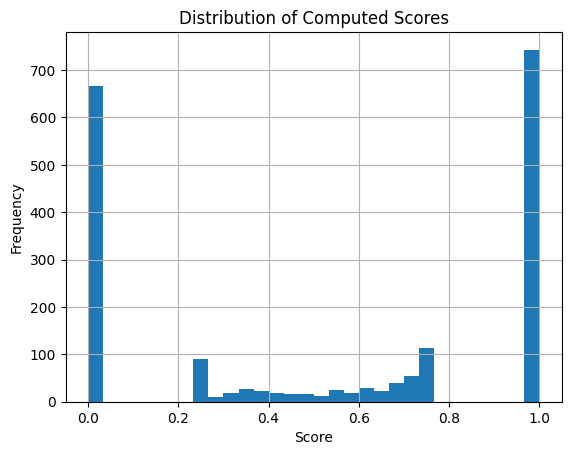

In [7]:
import matplotlib.pyplot as plt
scored_df['ComputedScore'].hist(bins=30)
plt.title('Distribution of Computed Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [8]:
llm_expanded = llm_df.copy()

llm_expanded = llm_expanded[llm_expanded['top3_list'].notnull()].copy()
llm_expanded = llm_expanded.explode('top3_list').rename(columns={'top3_list': 'Solver'}) 
llm_expanded['Solver'] = llm_expanded['Solver'].astype(str)
# Standardize matching keys
llm_expanded['problem'] = llm_expanded['problem'].astype(str)
llm_expanded['instance'] = llm_expanded['instance'].astype(str)
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)
scored_df['Solver'] = scored_df['Solver'].astype(str)

# Merge: (problem, instance, solver)
llm_scored = llm_expanded.merge(
    scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
    left_on=['problem', 'instance', 'Solver'],
    right_on=['Problem', 'Instance', 'Solver'],
    how='left'
)

llm_summary = (
    llm_scored
    .groupby(['provider', 'model'], as_index=False)['ComputedScore']
    .sum()
    .rename(columns={'ComputedScore': 'LLM_TotalScore'})
)

# Normalize by number of instances covered
llm_summary['InstancesCovered'] = (
    llm_scored.groupby(['provider', 'model'])[['problem', 'instance']]
    .nunique()
    .reset_index(drop=True)['instance']
)
llm_summary['LLM_AvgScore'] = llm_summary['LLM_TotalScore'] / llm_summary['InstancesCovered']

display(llm_summary.sort_values('LLM_AvgScore', ascending=False))

,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
14,groq,openai/gpt-oss-120b,162.683137,74,2.198421
12,groq,moonshotai/kimi-k2-instruct,164.426088,75,2.192348
13,groq,moonshotai/kimi-k2-instruct-0905,163.630619,75,2.181742
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,156.368064,72,2.171779
1,gemini,gemini-2.5-flash,176.339120,86,2.050455
0,gemini,gemini-2.0-flash,136.038062,67,2.030419
15,groq,openai/gpt-oss-20b,148.476305,75,1.979684
3,gemini,gemini-2.5-pro,100.112375,51,1.962988
6,groq,groq/compound-mini,68.575723,35,1.959306
2,gemini,gemini-2.5-flash-lite,160.567006,85,1.889024


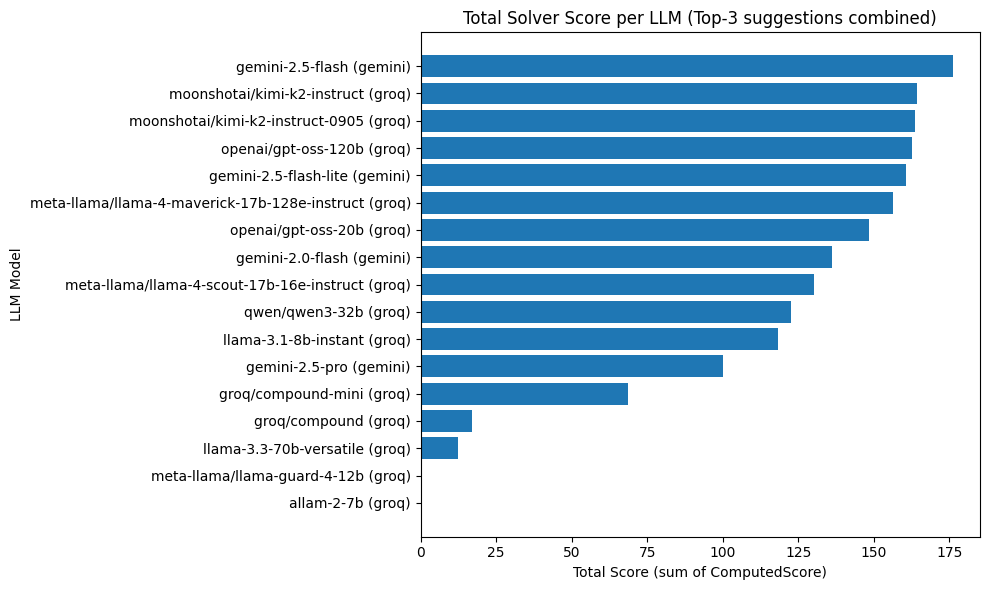

In [9]:
# Sort by total score
plot_df = llm_summary.sort_values('LLM_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-3 suggestions combined)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

# --- Extract Top-1 predictions only ---
llm_top1 = llm_df.copy()
llm_top1 = llm_top1[llm_top1['top1'].notnull()].copy()
llm_top1 = llm_top1.rename(columns={'top1': 'Solver'})
llm_top1['Solver'] = llm_top1['Solver'].astype(str)

# --- Standardize key names and merge with solver scores ---
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)
scored_df['Solver'] = scored_df['Solver'].astype(str)

llm_top1['problem'] = llm_top1['problem'].astype(str)
llm_top1['instance'] = llm_top1['instance'].astype(str)

llm_top1_scored = llm_top1.merge(
    scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
    left_on=['problem', 'instance', 'Solver'],
    right_on=['Problem', 'Instance', 'Solver'],
    how='left'
)

# --- Aggregate by (provider, model) ---
llm_top1_summary = (
    llm_top1_scored
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        LLM_Top1_TotalScore=('ComputedScore', 'sum'),
        LLM_Top1_AvgScore=('ComputedScore', 'mean'),
        InstancesCovered=('instance', 'nunique')
    )
)

# --- Sort descending by average score ---
llm_top1_summary = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=False)

display(llm_top1_summary)


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,gemini,gemini-2.5-flash-lite,62.448500,0.821691,85
1,gemini,gemini-2.5-flash,61.629788,0.770372,85
11,groq,moonshotai/kimi-k2-instruct,57.122616,0.852576,75
12,groq,moonshotai/kimi-k2-instruct-0905,55.940287,0.822651,75
13,groq,openai/gpt-oss-120b,54.422634,0.800333,74
14,groq,openai/gpt-oss-20b,54.410434,0.850163,75
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,54.053489,0.831592,72
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,50.561696,0.802567,69
15,groq,qwen/qwen3-32b,45.934275,0.850635,65
0,gemini,gemini-2.0-flash,45.512659,0.746109,67


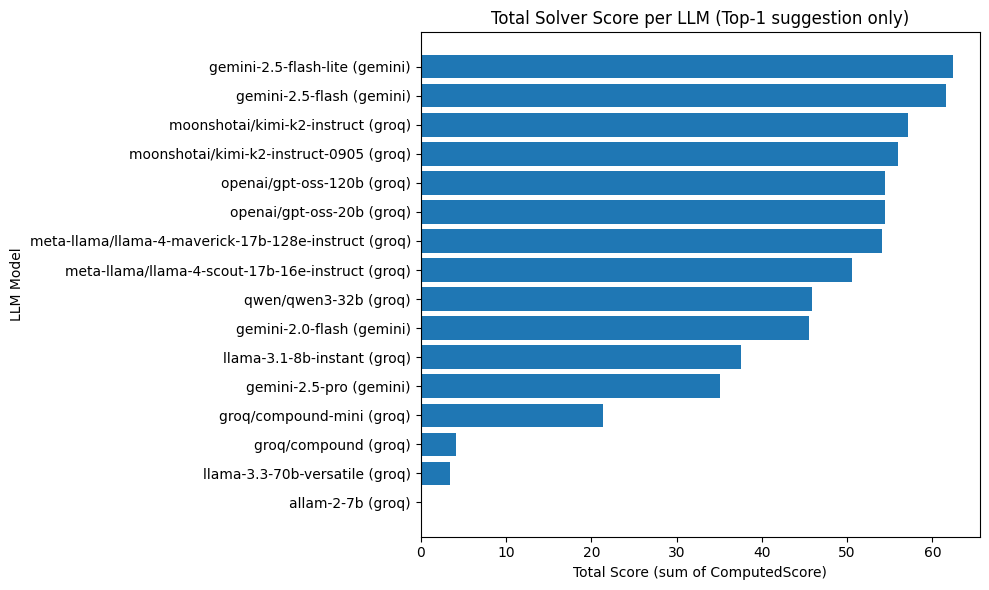

In [11]:
# Sort by total score
plot_df = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_Top1_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-1 suggestion only)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

### Closed-Gap (CG) Metric Calculation

The **closed-gap (cg)** metric measures how close a solver selection (in this case, the LLM’s chosen solver) is to the *Virtual Best Solver* (VBS), normalized against the *Single Best Solver* (SBS).

#### Formula

$$
cg = \frac{score_{all}(AS) - score_{all}(SBS)}{score_{all}(VBS) - score_{all}(SBS)}
$$

where:
- **AS** = Algorithm Selector (the solver predicted by the LLM)
- **VBS** = Virtual Best Solver — the solver that achieves the best score on each instance
- **SBS** = Single Best Solver — the single solver that performs best overall across the dataset  
  (in our case: `SBS = 'or-tools_cp-sat-free'`)

In [12]:
SBS_SOLVER = 'or-tools_cp-sat-free'

cg_results = []

# Compute VBS scores for all instances once
vbs_df = (
    scored_df.groupby(['Problem', 'Instance'], as_index=False)['ComputedScore']
    .max()
    .rename(columns={'ComputedScore': 'VBS_Score'})
)

for (prov, mod), group in llm_top1_scored.groupby(['provider', 'model']):
    # Instances this model actually made predictions for
    covered = group[['problem', 'instance']].drop_duplicates()
    
    # Subset SBS and VBS to same instance set
    vbs_sub = vbs_df.merge(
        covered,
        left_on=['Problem', 'Instance'],
        right_on=['problem', 'instance'],
        how='inner'
    )
    sbs_sub = scored_df[
        (scored_df['Solver'] == SBS_SOLVER)
        & (scored_df['Problem'].isin(covered['problem']))
        & (scored_df['Instance'].isin(covered['instance']))
    ]
    
    # Compute total scores normalized over same instance set
    score_AS = group['ComputedScore'].sum()
    score_VBS = vbs_sub['VBS_Score'].sum()
    score_SBS = sbs_sub['ComputedScore'].sum()

    # Compute closed gap
    cg = (score_AS - score_SBS) / (score_VBS - score_SBS) if (score_VBS - score_SBS) != 0 else float('nan')

    cg_results.append({
        'provider': prov,
        'model': mod,
        'InstancesCovered': len(covered),
        'AS': score_AS,
        'SBS': score_SBS,
        'VBS': score_VBS,
        'ClosedGap': cg,
    })

cg_df = pd.DataFrame(cg_results).sort_values('ClosedGap', ascending=False)
display(cg_df)

,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
3,gemini,gemini-2.5-pro,51,35.140862,35.201589,45.0,-0.006198
2,gemini,gemini-2.5-flash-lite,85,62.448500,62.585568,78.0,-0.008892
1,gemini,gemini-2.5-flash,85,61.629788,62.585568,78.0,-0.062006
11,groq,moonshotai/kimi-k2-instruct,75,57.122616,59.256236,68.0,-0.244016
0,gemini,gemini-2.0-flash,67,45.512659,48.857047,61.0,-0.275418
12,groq,moonshotai/kimi-k2-instruct-0905,75,55.940287,59.256236,68.0,-0.379236
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,72,54.053489,57.371511,65.0,-0.434951
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,69,50.561696,54.481700,62.0,-0.521395
13,groq,openai/gpt-oss-120b,74,54.422634,58.791641,67.0,-0.532263
14,groq,openai/gpt-oss-20b,75,54.410434,59.256236,68.0,-0.554201


## General classification of single solvers based on score

In [ ]:
score_solvers = []

for solver, group in scored_df.groupby('Solver'):
    total_score = group['ComputedScore'].sum()
    score_solvers.append({
        'Solver': solver,
        'TotalScore': total_score
    })
score_solvers_df = pd.DataFrame(score_solvers).sort_values('TotalScore', ascending=False)
display(score_solvers_df)



,Solver,TotalScore
13,or-tools_cp-sat-free,76.299457
4,chuffed-free,70.962662
15,picatsat-free,66.683307
2,choco-solver__cp-sat_-free,65.345290
10,huub-free,64.805679
11,izplus-free,62.758311
5,cp_optimizer-free,61.400375
8,gurobi-free,60.227161
16,pumpkin-free,59.835880
3,choco-solver__cp_-free,58.587601


## Confrontation between single solvers and LLMs 
### extraction of the five best models which will be the only one considered from now on

In [19]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores = llm_top1_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'model': 'Solver'})
# We drop LLM_Top1_AvgScore	InstancesCovered and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'provider'])

frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
display(generalScores_df) 
display(llm_totscores)

solver_list = llm_totscores['Solver'].head().astype(str).tolist()
print('==== Top 5 LLM Solvers ====')
print(solver_list)

,Solver,TotalScore
13,or-tools_cp-sat-free,76.299457
4,chuffed-free,70.962662
15,picatsat-free,66.683307
2,choco-solver__cp-sat_-free,65.345290
10,huub-free,64.805679
11,izplus-free,62.758311
2,gemini-2.5-flash-lite,62.448500
1,gemini-2.5-flash,61.629788
5,cp_optimizer-free,61.400375
8,gurobi-free,60.227161


,Solver,TotalScore
2,gemini-2.5-flash-lite,62.448500
1,gemini-2.5-flash,61.629788
11,moonshotai/kimi-k2-instruct,57.122616
12,moonshotai/kimi-k2-instruct-0905,55.940287
13,openai/gpt-oss-120b,54.422634
14,openai/gpt-oss-20b,54.410434
9,meta-llama/llama-4-maverick-17b-128e-instruct,54.053489
10,meta-llama/llama-4-scout-17b-16e-instruct,50.561696
15,qwen/qwen3-32b,45.934275
0,gemini-2.0-flash,45.512659


==== Top 5 LLM Solvers ====
['gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct', 'moonshotai/kimi-k2-instruct-0905', 'openai/gpt-oss-120b']
